# 1. Load the MNIST dataset

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

# print out the keys
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
# look at the arrays for:
# data key: an array with one row per instance and one column per feature
# target key: contans an array with the labels

X, y =  mnist["data"], mnist["target"]

print("The shape of the data key")
X.shape

The shape of the data key


(70000, 784)

In [3]:
print("The shape of the target key")
y.shape

The shape of the target key


(70000,)

In [4]:
import matplotlib as mlp
import matplotlib.pyplot as plt

# show an image of one charactor by getting the feature vector, reshape it to 28x28 array, then display with imshow()
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap = mlp.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

<Figure size 640x480 with 1 Axes>

In [5]:
# check the label to see if it is correct
y[0]

'5'

In [6]:
import numpy as np

# convert the string labels to integers
y = y.astype(np.uint8)

# 2. Split the data into training/test sets

In [7]:
# The mnist training set is already split, first 60,000 train, last 10,000 test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3. Train a Binary Classifier

In [8]:
# create target vectors for classification (5 or not 5)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
# pick a clasifier and train: Stochastic Gradient Descent (SGD)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
# check and see if the digit from above is a 5
sgd_clf.predict([some_digit])

array([ True])

In [11]:
# implement cross-fold validation yourself
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


# 4. Measuring Accuracy Using Cross-Validation

In [12]:
# evaluate SGDClassifier using k-fold validation
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# is the accuracy a good measure?  
# lets try a very dumb classifier that always classifies an image as not 5
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# this never 5 classifier has accuracy around 90%! 
# this is because approx 90 percent are not 5's

array([0.91125, 0.90855, 0.90915])

# 5. Confusion Matrix

In [14]:
# a confusion matrix will show the mis-identifications

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# cross_val_predict performs k-fold cross validation but returns the predictions on each test fold. 
# this gives a clean prediction for each instance in the training set
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# pass the target class and predicted class to confusion_matrix()
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [15]:
# perfect classifier would have only true positives and true ngatives.
y_train_perfect_predictions = y_train_5  # pretend we are perfect
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

# 7. Precision and Recall

In [16]:
# compute precision and recall
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # how often the images identified as a 5 are actually 5s

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred)  # what percentage of the 5s it can find

# the classifier results are not as strong when viewed through multiple metrics

0.6511713705958311

In [18]:
# precision and recall can be combined in f score
# this is the harmonic mean of precision and recall, the f score is only high if both recall and precision are high
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision vs Recall Trade-Off

In [19]:
# you can't set the decision threshold manually, but you can access the decision scores use to make predictions
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [20]:
# SGD Classifier uses a threshold of 0 so the result is the same
threshold = 0
y_some_digit_predict = (y_scores > threshold)
y_some_digit_predict

# the classifier detects the 5

array([ True])

In [21]:
# raising the threshold decreases recall
threshold = 200000
y_some_digit_predict = (y_scores > threshold)
y_some_digit_predict

# the classifier can't detect the 5

array([False])

In [22]:
# determine which decision threshold to use
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

## Precision and recall graph

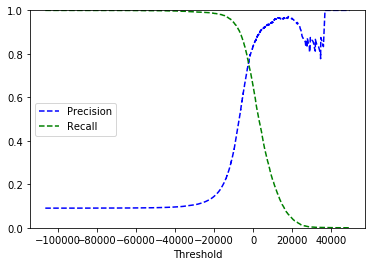

In [23]:
from sklearn.metrics import precision_recall_curve

# set up the information needed
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# plot the curves
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()    

In [24]:
# choose a threshold (70,000 for this example @ 90%)
y_train_pred_90 = (y_scores > 3000)

# check for precision and recall
precision_score(y_train_5, y_train_pred_90)

0.8911317008603574

In [25]:
recall_score(y_train_5, y_train_pred_90)

0.4967718133185759

## The ROC curver
Plots the true positive rate (recall) against the false positive rate.

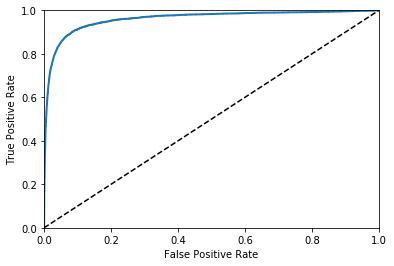

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [27]:
# to determine if the classifier is good, calculate the area under the curve.
# random area would be = .5, perfect would be = 1
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [28]:
# compare to a random forest, usie dict_prob() instead of decision_function
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

/home/charlotte/PycharmProjects/CIS-6930-AI/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/charlotte/PycharmProjects/CIS-6930-AI/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/charlotte/PycharmProjects/CIS-6930-AI/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [29]:
# get scores, not probabilities
y_scores_forest = y_probas_forest[:, 1] # score is the probability of a  positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

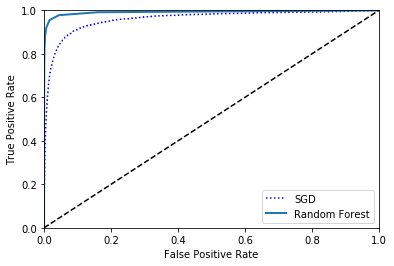

In [30]:
# plot the curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [31]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

## Multiclass Classification
Random Forest and Naive Bayes can handle multiple classes directly.

Support Vector Machines and Linear classifiers are only binary classifiers, but they can be used to classify multiple classes with some modification.

One versus All (OvA): train a separate classifer for each class and then run them all and look at the scores.

One versus One (OvO): trains each one against another one.

Scikit-learn will automatically use OvA when you run a binary classifier for a classification task (except for SVM where it scales poorly, it will use OvO)

In [32]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
# sci-kit learn trained 10 classifiers, then got the scores and chose the best one.

array([3], dtype=uint8)

In [33]:
#  if you call decision function you will see 10 scores instead of one.

some_digit_scores= sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [34]:
# the highest one is the one that corresponds to class 5
np.argmax(some_digit_scores)

3

In [35]:
# print out the corresponding classes
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [39]:
sgd_clf.classes_[3]

3

In [38]:
# force sklearn to use OvO or OvA
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])


array([5], dtype=uint8)

In [40]:
# a random forest doesn't require OvO or OvA
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/home/charlotte/PycharmProjects/CIS-6930-AI/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5], dtype=uint8)

In [41]:
# get the probabilities
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [42]:
# evaluate the accuracy with cross fold validation
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87082583, 0.87089354, 0.88628294])

In [44]:
# scaling the inputs helps to improve accuracy
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


/home/charlotte/PycharmProjects/CIS-6930-AI/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

## Error Analysis

In [45]:
# look at the confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/home/charlotte/PycharmProjects/CIS-6930-AI/venv/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]])

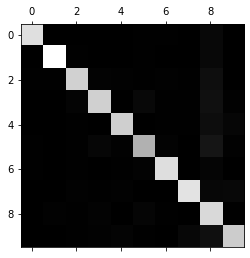

In [46]:
# view confusion matrix as a graph
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

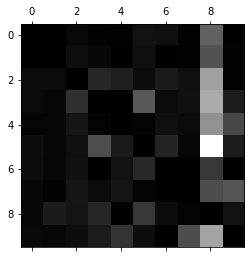

In [47]:
# divide each value in the confusion matrix by the total number of images in the class, there might not be an even number
# this compares error rates instead of absolute error
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx /row_sums

# fill the diagnol with zeros, to keep only errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()
# by viewing the above, we can target the areas where the classifier is not good, and work on improvement

## Multilabel Classification

In [49]:
# classify if a number is odd and if the number is large
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
# this method uses the f score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

## Multioutput Classifiation

In [ ]:
# each label can be multi-class
# remove noise from image, output has a label for each pixel, each label can have multiple values.

# first create training and test sets by adding noise to MNIST images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test


In [ ]:
# make a classifer to clean the image
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)